In [1]:
!rm libdevice.10.bc
!ln -s /opt/conda/nvvm/libdevice/libdevice.10.bc ./libdevice.10.bc

# RANDOM SEED = 42
import numpy as np
import random
import tensorflow as tf
import os

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds(42)

2025-06-26 19:17:01.361384: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-26 19:17:01.586259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750965421.615357    1282 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750965421.627697    1282 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-26 19:17:01.873224: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# LOAD DATASET

import boto3

bucket_name = 'ct-patches-nogroundtruths'
object_key = 'CT_patches_combined.npz'
download_path = './CT_patches_combined.npz'

s3 = boto3.client('s3')
s3.download_file(bucket_name, object_key, download_path)

print("Downloaded CT_patches_combined.npz")

data = np.load('CT_patches_combined.npz')
patches = data['patches']
labels = data['labels']

print("Label distribution:", np.bincount(labels))

# SPLIT INTO TRAINING & TESTING DATA

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Reshape patches to include channel dimension (grayscale = 1)
patches = patches[..., np.newaxis]  # (N, 32, 32) → (N, 32, 32, 1)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    patches, labels, test_size=0.15, random_state=42, stratify=labels
)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

Downloaded CT_patches_combined.npz
Label distribution: [1168556   50004]
Training set: (1035776, 32, 32, 1) (1035776,)
Validation set: (182784, 32, 32, 1) (182784,)


I0000 00:00:1750965443.220950    1282 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5
W0000 00:00:1750965444.286755    1389 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /opt/conda/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /opt/conda/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /opt/conda/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting th

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fixed_laplacian     │ (None, 32, 32, 1) │          0 │ input_layer[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        640 │ fixed_laplacian[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │        128 │ fixed_laplacian[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d_1[0][0],   │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ leaky_re_lu_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │    147,584 │ leaky_re_lu_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 16,    │          0 │ conv2d_4[0][0],   │
│                     │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ add_1[0][0]       │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ leaky_re_lu_3[0]

 Total params: 456,372 (1.74 MB)

 Trainable params: 456,116 (1.74 MB)

 Non-trainable params: 256 (1.00 KB)

Stage 1: Training with Binary Crossentropy (Epochs 1–5)
Epoch 1/5


I0000 00:00:1750965451.284345    1384 service.cc:148] XLA service 0x7f0c880681f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750965451.284377    1384 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-06-26 19:17:31.581009: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750965452.360665    1384 cuda_dnn.cc:529] Loaded cuDNN version 91001
2025-06-26 19:17:34.889434: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,32,32]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation

16184/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6679 - auc: 0.7180 - loss: 0.5934 - precision: 0.6192 - recall: 0.8720

2025-06-26 19:25:53.254611: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,32,32]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-26 19:25:53.305580: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}, f32[32,64,32,32]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="


Epoch 1: val_recall improved from -inf to 0.33636, saving model to CT_CCNN_model_laplacian.h5


16184/16184 ━━━━━━━━━━━━━━━━━━━━ 529s 31ms/step - accuracy: 0.6679 - auc: 0.7180 - loss: 0.5934 - precision: 0.6192 - recall: 0.8720 - val_accuracy: 0.8631 - val_auc: 0.7628 - val_loss: 0.3098 - val_precision: 0.1118 - val_recall: 0.3364
Epoch 2/5
16183/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7183 - auc: 0.7887 - loss: 0.5359 - precision: 0.6696 - recall: 0.8618
Epoch 2: val_recall improved from 0.33636 to 0.36582, saving model to CT_CCNN_model_laplacian.h5


16184/16184 ━━━━━━━━━━━━━━━━━━━━ 502s 31ms/step - accuracy: 0.7183 - auc: 0.7887 - loss: 0.5359 - precision: 0.6696 - recall: 0.8618 - val_accuracy: 0.8620 - val_auc: 0.7601 - val_loss: 0.3022 - val_precision: 0.1182 - val_recall: 0.3658
Epoch 3/5
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7319 - auc: 0.8032 - loss: 0.5185 - precision: 0.6827 - recall: 0.8665
Epoch 3: val_recall did not improve from 0.36582
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 523s 32ms/step - accuracy: 0.7319 - auc: 0.8032 - loss: 0.5185 - precision: 0.6827 - recall: 0.8665 - val_accuracy: 0.9150 - val_auc: 0.7677 - val_loss: 0.2234 - val_precision: 0.1394 - val_recall: 0.2072
Epoch 4/5
16183/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7443 - auc: 0.8158 - loss: 0.5023 - precision: 0.6942 - recall: 0.8733
Epoch 4: val_recall improved from 0.36582 to 0.46580, saving model to CT_CCNN_model_laplacian.h5


16184/16184 ━━━━━━━━━━━━━━━━━━━━ 523s 32ms/step - accuracy: 0.7443 - auc: 0.8158 - loss: 0.5023 - precision: 0.6942 - recall: 0.8733 - val_accuracy: 0.8228 - val_auc: 0.7767 - val_loss: 0.3381 - val_precision: 0.1096 - val_recall: 0.4658
Epoch 5/5
16183/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7598 - auc: 0.8298 - loss: 0.4842 - precision: 0.7100 - recall: 0.8784
Epoch 5: val_recall did not improve from 0.46580
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 517s 32ms/step - accuracy: 0.7598 - auc: 0.8298 - loss: 0.4842 - precision: 0.7100 - recall: 0.8784 - val_accuracy: 0.8706 - val_auc: 0.7656 - val_loss: 0.2781 - val_precision: 0.1199 - val_recall: 0.3393
Restoring model weights from the end of the best epoch: 4.
Stage 2: Training with Hybrid Loss (Epochs 6–20)
Epoch 1/15
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7585 - auc: 0.8291 - loss: 0.2967 - precision: 0.7047 - recall: 0.8898
Epoch 1: val_recall improved from 0.46580 to 0.54379, saving model to CT_CCNN_model_

16184/16184 ━━━━━━━━━━━━━━━━━━━━ 550s 33ms/step - accuracy: 0.7585 - auc: 0.8291 - loss: 0.2967 - precision: 0.7047 - recall: 0.8898 - val_accuracy: 0.7783 - val_auc: 0.7752 - val_loss: 0.2362 - val_precision: 0.0990 - val_recall: 0.5438
Epoch 2/15
16183/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7732 - auc: 0.8421 - loss: 0.2883 - precision: 0.7203 - recall: 0.8932
Epoch 2: val_recall did not improve from 0.54379
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 538s 33ms/step - accuracy: 0.7732 - auc: 0.8421 - loss: 0.2883 - precision: 0.7203 - recall: 0.8932 - val_accuracy: 0.8085 - val_auc: 0.7740 - val_loss: 0.2245 - val_precision: 0.1055 - val_recall: 0.4899
Epoch 3/15
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7842 - auc: 0.8517 - loss: 0.2818 - precision: 0.7314 - recall: 0.8983
Epoch 3: val_recall did not improve from 0.54379
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 533s 33ms/step - accuracy: 0.7842 - auc: 0.8517 - loss: 0.2818 - precision: 0.7314 - recall: 0.8983 - val_acc

16184/16184 ━━━━━━━━━━━━━━━━━━━━ 524s 32ms/step - accuracy: 0.8049 - auc: 0.8733 - loss: 0.2682 - precision: 0.7543 - recall: 0.9045 - val_accuracy: 0.7566 - val_auc: 0.7709 - val_loss: 0.2661 - val_precision: 0.0965 - val_recall: 0.5898
Epoch 6/15
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8158 - auc: 0.8829 - loss: 0.2614 - precision: 0.7666 - recall: 0.9081
Epoch 6: val_recall did not improve from 0.58979
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 532s 33ms/step - accuracy: 0.8158 - auc: 0.8829 - loss: 0.2614 - precision: 0.7666 - recall: 0.9081 - val_accuracy: 0.8698 - val_auc: 0.7676 - val_loss: 0.1978 - val_precision: 0.1216 - val_recall: 0.3489
Epoch 7/15
16183/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8240 - auc: 0.8909 - loss: 0.2558 - precision: 0.7760 - recall: 0.9108
Epoch 7: val_recall did not improve from 0.58979
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 532s 33ms/step - accuracy: 0.8240 - auc: 0.8909 - loss: 0.2558 - precision: 0.7760 - recall: 0.9108 - val_acc

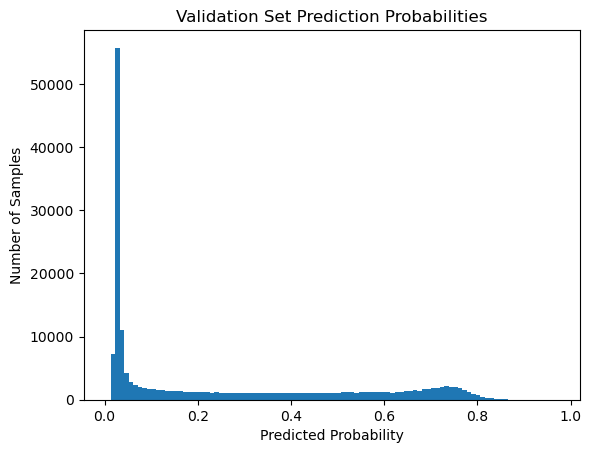

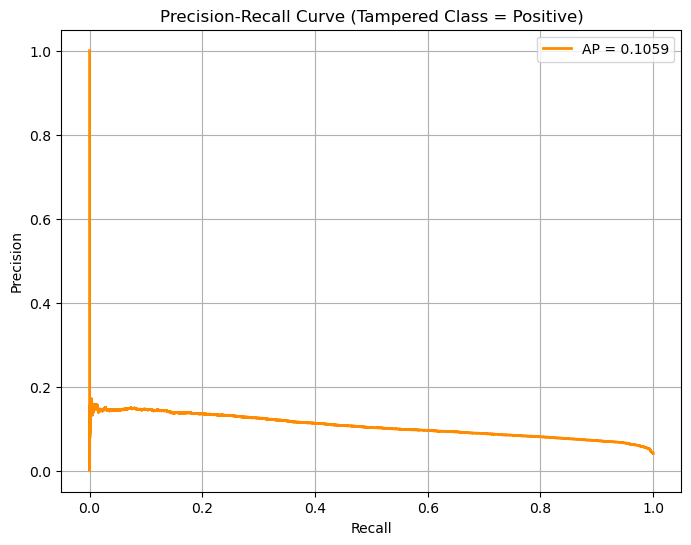

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, Input, Dense, BatchNormalization, 
                                     MaxPooling2D, Dropout, Add, LeakyReLU, 
                                     GlobalAveragePooling2D, Reshape, multiply, 
                                     GlobalMaxPooling2D, Concatenate, Lambda, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import backend as K

# SETTINGS
PATCH_SIZE = 32
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4
MODEL_PATH = 'CT_CCNN_model_laplacian.h5'
VALIDATION_SPLIT = 0.15
L2_REG = 1e-5

# FIXED LAPLACIAN LAYER
def fixed_laplacian_layer(x):
    laplacian_kernel = np.array([[0, 1, 0],
                                  [1, -4, 1],
                                  [0, 1, 0]], dtype=np.float32).reshape((3, 3, 1, 1))
    kernel_tensor = tf.constant(laplacian_kernel)
    return tf.nn.conv2d(x, filters=kernel_tensor, strides=1, padding='SAME')

# LOSS FUNCTIONS
def focal_loss(gamma=2., alpha=0.5): 
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + \
                 (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        return K.mean(weight * cross_entropy, axis=-1)
    return focal_loss_fixed

def hybrid_loss_with_smoothed_bce(gamma=2.0, alpha=0.55, bce_weight=0.5, smoothing=0.05):
    fl = focal_loss(gamma=gamma, alpha=alpha)
    bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=smoothing)
    def loss_fn(y_true, y_pred):
        return bce_weight * bce(y_true, y_pred) + (1 - bce_weight) * fl(y_true, y_pred)
    return loss_fn

# CBAM BLOCK
def cbam_block(x, ratio=8):
    channel = x.shape[-1]
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)

    shared_dense = Dense(channel // ratio, activation='relu', kernel_regularizer=l2(L2_REG))
    shared_out = Dense(channel, kernel_regularizer=l2(L2_REG))

    avg_out = shared_out(shared_dense(avg_pool))
    max_out = shared_out(shared_dense(max_pool))
    channel_attention = Add()([avg_out, max_out])
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_attention = Reshape((1, 1, channel))(channel_attention)
    x = multiply([x, channel_attention])

    avg_pool_spatial = Lambda(lambda t: K.mean(t, axis=3, keepdims=True))(x)
    max_pool_spatial = Lambda(lambda t: K.max(t, axis=3, keepdims=True))(x)
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid',
                               kernel_regularizer=l2(L2_REG))(concat)
    x = multiply([x, spatial_attention])
    return x

# BUILD CCNN
def build_ccnn(input_shape=(32, 32, 1)):
    inputs = Input(shape=input_shape)
    
    # Fixed Laplacian layer
    x = Lambda(fixed_laplacian_layer, name='fixed_laplacian')(inputs)

    # Residual block 1
    res = x
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(res)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(x)
    res = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(L2_REG))(res)
    x = Add()([x, res])
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Residual block 2
    res2 = x
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(res2)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(x)
    res2 = Conv2D(128, (1, 1), padding='same', kernel_regularizer=l2(L2_REG))(res2)
    x = Add()([x, res2])
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = cbam_block(x)

    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=l2(L2_REG),
                        pointwise_regularizer=l2(L2_REG))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=l2(L2_REG),
                        pointwise_regularizer=l2(L2_REG))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=l2(L2_REG),
                        pointwise_regularizer=l2(L2_REG))(x)
    x = LeakyReLU(negative_slope=0.1)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(L2_REG))(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(L2_REG))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(LEARNING_RATE),
        loss=hybrid_loss_with_smoothed_bce(gamma=2.0, alpha=0.55, bce_weight=0.5, smoothing=0.05),
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )
    return model
    
# CLASS BALANCE IN TRAINING

def balanced_batch_generator(tampered_X, tampered_y, untampered_X, untampered_y, batch_size):
    n = batch_size // 2

    tampered_indices = np.arange(len(tampered_X))
    untampered_indices = np.arange(len(untampered_X))

    while True:
        tampered_sample_idx = np.random.choice(tampered_indices, size=n, replace=True)
        untampered_sample_idx = np.random.choice(untampered_indices, size=n, replace=False)

        batch_X = np.concatenate([tampered_X[tampered_sample_idx], untampered_X[untampered_sample_idx]], axis=0)
        batch_y = np.concatenate([tampered_y[tampered_sample_idx], untampered_y[untampered_sample_idx]], axis=0)

        perm = np.random.permutation(len(batch_y))
        yield batch_X[perm], batch_y[perm]

# SPLIT TRAINING DATA BY LABEL

tampered_mask = (y_train == 1)
untampered_mask = (y_train == 0)

tampered_X_train = X_train[tampered_mask]
tampered_y_train = y_train[tampered_mask]
untampered_X_train = X_train[untampered_mask]
untampered_y_train = y_train[untampered_mask]

# COMPILE CCNN

model = build_ccnn()
model.summary()

# UPDATE CCNN & EARLY STOPPING

checkpoint = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_recall',
    mode='max',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# GENERATE TRAINING BATCHES

train_generator = balanced_batch_generator(
    tampered_X_train, tampered_y_train,
    untampered_X_train, untampered_y_train,
    batch_size=BATCH_SIZE
)

steps_per_epoch = len(y_train) // BATCH_SIZE

# TRAIN CCNN

# Define BCE and hybrid loss separately
bce_loss = tf.keras.losses.BinaryCrossentropy()
hybrid = hybrid_loss_with_smoothed_bce(gamma=2.0, alpha=0.55, bce_weight=0.5, smoothing=0.05)

# Stage 1 (Epochs 1-5): Train with BCE
print("Stage 1: Training with Binary Crossentropy (Epochs 1–5)")
model.compile(
    optimizer=Adam(LEARNING_RATE),
    loss=bce_loss,
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

history_bce = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, earlystop],
    shuffle=False
)

# Stage 2 (Epochs 6-Stop): Train with Hybrid Loss
print("Stage 2: Training with Hybrid Loss (Epochs 6–20)")
model.compile(
    optimizer=Adam(LEARNING_RATE),
    loss=hybrid,
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

history_hybrid = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS - 5,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, earlystop],
    shuffle=False
)

# THRESHOLD EVALUATION

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score

y_val_probs = model.predict(X_val)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for thresh in thresholds:
    y_val_pred = (y_val_probs > thresh).astype(int)
    print(f"--- Threshold: {thresh} ---")
    print(classification_report(y_val, y_val_pred, digits=4))
    print(f"AUROC (using probs): {roc_auc_score(y_val, y_val_probs):.4f}\n")

# PROBABILITY VS. NUMBER OF SAMPLES GRAPH

plt.hist(y_val_probs, bins=100)
plt.title("Validation Set Prediction Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Samples")
plt.show()

# Get predicted probabilities
y_scores = y_val_probs.ravel() 

# PRECISION VS. RECALL GRAPH

# Compute PR curve & area under PR curve
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
avg_precision = average_precision_score(y_val, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AP = {avg_precision:.4f}", color="darkorange", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Tampered Class = Positive)")
plt.grid(True)
plt.legend(loc="upper right")
plt.show()